### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import requests
import zipfile
import shutil
from datetime import datetime, timedelta
from google.cloud import bigquery
from google.oauth2 import service_account
import yaml

### Preparation of BigQuery connection parameters

In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

PROJECT_ID = config['PROJECT_ID']
DATASET_NAME = config['DATASET_NAME']
TABLE_NAME = config['TABLE_NAME']
JSON_KEY_BQ = config['JSON_KEY_BQ']

In [3]:
key_path = f"../{JSON_KEY_BQ}"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

### Establishing the BigQuery connection and downloading from there the data to be analyzed

In [4]:
query = """
SELECT * FROM `airflow_dataset.reporting_results2020`
"""

df = client.query(query).to_dataframe()

### Displaying a sample of downloaded data

In [5]:
df.head()

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,...,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali
0,<NA>,ST-DL-BO/ZGŁOSZENIE/266/2024,2834.2024.DG,2024-02-02,Starosta Powiatu Bolesławiec,dolnośląskie,59-730,Milików,201045,None,...,None,Brak sprzeciwu,020104_5,6,341/16,None,Kosyl,Agnieszka,153/DOŚ/10,Anna Dąbrowska nr upr. 128/DOŚ/10
1,<NA>,ST-DL-BO/ZGŁOSZENIE/266/2024,2834.2024.DG,2024-02-02,Starosta Powiatu Bolesławiec,dolnośląskie,59-730,Milików,201045,None,...,None,Brak sprzeciwu,020104_5,6,342/6,None,Kosyl,Agnieszka,153/DOŚ/10,Anna Dąbrowska nr upr. 128/DOŚ/10
2,<NA>,ST-DL-BO/ZGŁOSZENIE/266/2024,2834.2024.DG,2024-02-02,Starosta Powiatu Bolesławiec,dolnośląskie,59-730,Milików,201045,None,...,None,Brak sprzeciwu,020104_5,6,342/2,None,Kosyl,Agnieszka,153/DOŚ/10,Anna Dąbrowska nr upr. 128/DOŚ/10
3,<NA>,ST-DL-BO/ZGŁOSZENIE/266/2024,2834.2024.DG,2024-02-02,Starosta Powiatu Bolesławiec,dolnośląskie,59-730,Milików,201045,None,...,None,Brak sprzeciwu,020104_5,6,624,None,Kosyl,Agnieszka,153/DOŚ/10,Anna Dąbrowska nr upr. 128/DOŚ/10
4,<NA>,ST-DL-LU/ZGŁOSZENIE/519/2024,7851,2024-03-01,Starosta Lubiński,dolnośląskie,None,Lubin,211011,None,...,None,Brak sprzeciwu,021101_1,2,302/30,None,Panic,Renata,127/DOŚ/11,None


### Categories of building permits

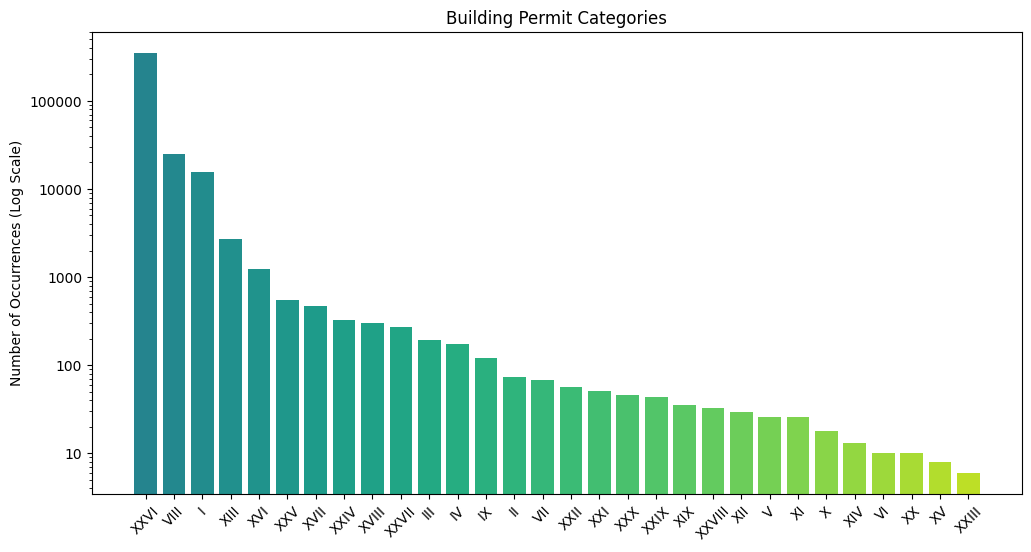

In [6]:
def categories_counter_log(df):
    counter = Counter()
    
    for record in df['kategoria']:
        counter[record] += 1

    # Sorting the data
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create color gradient for the plot
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Plot details
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Building Permit Categories')
    
    # Set Y-axis to logarithmic scale
    plt.yscale('log')

    # Format Y-axis labels as actual numbers instead of powers of 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

categories_counter_log(df)


### Names of construction intention type

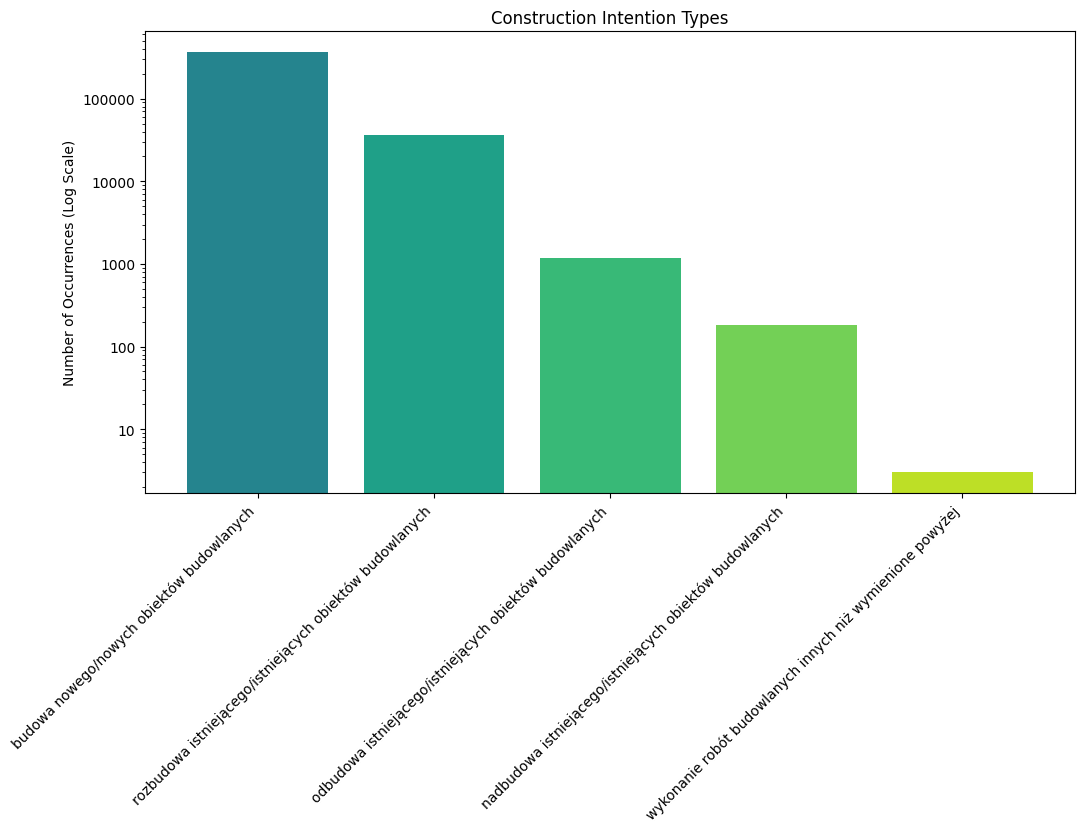

In [7]:
def construction_intention_counter_log(df, column_name):
    counter = Counter()
    
    for record in df[column_name]:
        counter[record] += 1
        
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Adjust np.linspace to match the number of categories in sorted_data
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')  
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Construction Intention Types')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    plt.show()

construction_intention_counter_log(df, 'rodzaj_zam_budowlanego')


### Date of receipt of the build application (by month)

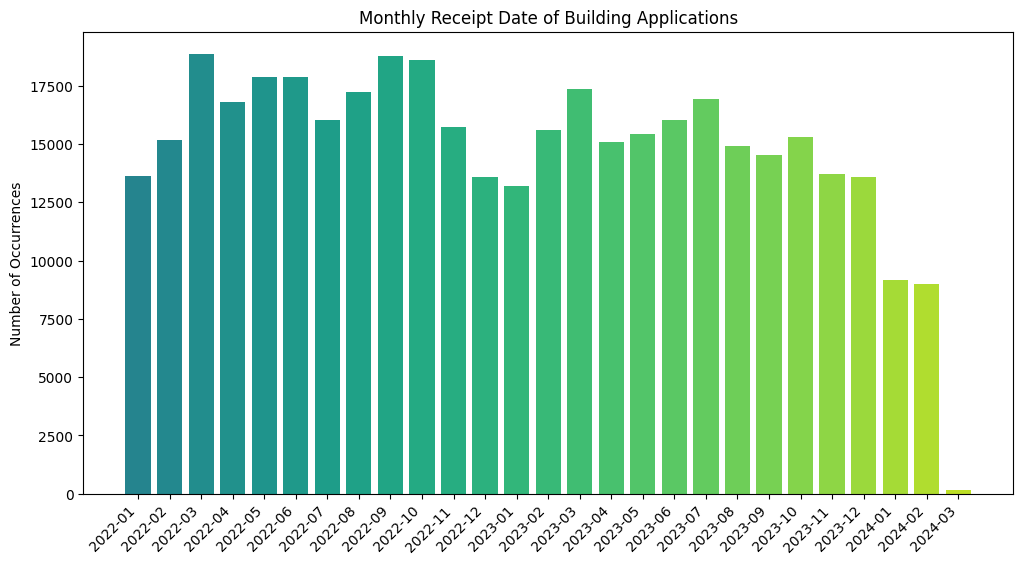

In [8]:
def monthly_receipt_date_counter(df, column_name):
    # Convert column to datetime
    df[column_name] = pd.to_datetime(df[column_name])

    # Group by year and month
    df['YearMonth'] = df[column_name].dt.to_period('M')

    # Count occurrences by month
    counter = Counter(df['YearMonth'])

    # Sort data by date (YearMonth) instead of occurrences
    sorted_data = dict(sorted(counter.items()))

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Convert PeriodIndex to string for plotting
    sorted_keys = [str(key) for key in sorted_data.keys()]
    plt.bar(sorted_keys, sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Occurrences')
    plt.title('Monthly Receipt Date of Building Applications')

    plt.show()

monthly_receipt_date_counter(df, 'data_wplywu_wniosku_do_urzedu')

### Teritorial units downloading

In [9]:
url = 'https://www.gis-support.pl/downloads/2022/powiaty.zip'
local_zip_path = 'zip_data.zip'
extract_to_folder = 'unpacked_zip_data_files'
shapefile_path = 'unpacked_zip_data_files/powiaty.shp'

def download_and_unpack_zip(url, local_zip_path, extract_to_folder):
    # Start downloading the ZIP file
    print("Starting to download the ZIP file...")
    response = requests.get(url)
    
    # Save the downloaded ZIP file locally
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)
    
    # ZIP file downloaded, start extracting it
    print("ZIP file downloaded. Starting the extraction...")
    
    # Check if the extract_to_folder already exists
    if os.path.exists(extract_to_folder):
        print(f"Removing existing folder: {extract_to_folder}")
        shutil.rmtree(extract_to_folder)
    
    # Create the folder before extraction
    os.makedirs(extract_to_folder)
    
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
    
    # Extraction completed
    print("Extraction finished.")
    
    # Remove the downloaded ZIP file from the working directory
    os.remove(local_zip_path)

download_and_unpack_zip(url, local_zip_path, extract_to_folder)

gdf = gpd.read_file(shapefile_path)

Starting to download the ZIP file...
ZIP file downloaded. Starting the extraction...
Removing existing folder: unpacked_zip_data_files
Extraction finished.


### Displaying a sample of downloaded teritorial units data

In [10]:
pd.set_option('display.max_columns', None)
gdf.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,JPT_NAZWA1,JPT_ORGAN1,JPT_WAZNA_,ID_BUFORA_,ID_BUFORA1,ID_TECHNIC,IIP_PRZEST,IIP_IDENTY,IIP_WERSJA,JPT_KJ_IIP,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,92617,1807,powiat krośnieński,None,13415,20210128,0,20170101,0,None,None,NZN,BRK,201859,0,1331302,PL.PZGIK.200,798ef296-2055-4890-993f-d414c67164ab,2021-01-28T13:43:40+01:00,EGIB,1807,None,None,UZG,0,1359583,0,None,0,0,3.11205337354,.12332626559,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21..."
1,None,POW,141297,2804,powiat elbląski,None,13422,20210514,0,20120926,0,None,None,NZN,NZN,218263,0,829271,PL.PZGIK.200,61a0d267-58aa-4f3a-86e7-faa281e50ebc,2021-05-14T13:19:46+02:00,EGIB,2804,None,None,UZG,0,1360107,0,None,0,0,4.2521309989,.19417975633,17074769000000,powiat,"POLYGON ((551842.165 693417.652, 551870.912 69..."
2,None,POW,209827,1415,powiat ostrołęcki,None,13409,20210518,0,20120926,0,None,None,NZN,NZN,219096,0,829100,PL.PZGIK.200,d2f96418-0366-4f59-8793-fef1aa0ca19f,2021-05-18T08:56:02+02:00,EGIB,1415,None,None,UZG,0,1360143,0,None,0,0,5.31641009622,.28125317026,55066883500000,powiat,"POLYGON ((646230.458 617154.258, 646336.602 61..."
3,None,POW,79097,0413,powiat sępoleński,None,13424,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829353,PL.PZGIK.200,09447bc4-a3c3-4d84-83ab-d61a69820974,2022-01-12T10:03:23+01:00,EGIB,0413,None,None,UZG,0,1362180,0,None,0,0,2.00313300009,.10690160786,09235092600000,powiat,"POLYGON ((384997.245 615178.269, 385170.687 61..."
4,None,POW,126576,3019,powiat pilski,None,13417,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829157,PL.PZGIK.200,196c6cd5-4f8d-4e98-a653-e0a36ccac728,2022-01-12T10:03:23+01:00,EGIB,3019,None,None,UZG,0,1362184,0,None,0,0,4.17134504707,.17008216429,57079948000000,powiat,"POLYGON ((342585.530 579834.380, 342632.859 57..."


### Applying voivodships and powiats' names to records of build permits data

In [11]:
# Dictionary with mappings of voivodeship codes to voivodeship names
voivodeships = {
    '02': 'Lower Silesian',
    '04': 'Kuyavian-Pomeranian',
    '06': 'Lublin',
    '08': 'Lubusz',
    '10': 'Lodz',
    '12': 'Lower Poland',
    '14': 'Masovian',
    '16': 'Opole',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomeranian',
    '24': 'Silesian',
    '26': 'Swietokrzyskie',
    '28': 'Warmian-Masurian',
    '30': 'Greater Poland',
    '32': 'West Pomeranian',
}

bad_voivod_temp_iter = 0
good_voivod_temp_iter = 0
bad_powiat_temp_iter = 0
good_powiat_temp_iter = 0

# Function for assigning voivodeship names based on TERYT code
def terc_to_voivodeship(terc_code):
    global bad_voivod_temp_iter
    global good_voivod_temp_iter
    voivodeship_code = terc_code[:2]
    
    # Check if the voivodeship code exists in the dictionary
    if voivodeship_code in voivodeships:
        voivodeship = voivodeships[voivodeship_code]
        good_voivod_temp_iter = good_voivod_temp_iter+1
    else:
        voivodeship = 'Unknown'
        bad_voivod_temp_iter = bad_voivod_temp_iter+1
        #print(f"ERROR for Voivodship: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
    
    return voivodeship

# Create a nested dictionary to map powiat codes to powiat names
powiat_mapping = {}

for index, row in gdf.iterrows():
    kod_je = row['JPT_KOD_JE']
    nazwa = row['JPT_NAZWA_']
    
    # Extract the first two digits as the outer key and the next two digits as the inner key
    outer_key = kod_je[:2]
    inner_key = kod_je[2:]
    
    # Initialize the outer dictionary if it doesn't exist
    if outer_key not in powiat_mapping:
        powiat_mapping[outer_key] = {}
    
    # Assign the value in the nested dictionary
    powiat_mapping[outer_key][inner_key] = nazwa
    

def terc_to_powiat(terc_code):
    global bad_powiat_temp_iter
    global good_powiat_temp_iter
    voivodship_code = terc_code[0:2]
    powiat_code = terc_code[2:4]
    
    # Initialize the powiat variable with "Unknown" as a default
    powiat = 'Unknown'
    
    # Check if the voivodship_code exists in powiat_mapping
    if voivodship_code in powiat_mapping:
        # Check if the powiat_code exists in the voivodship's dictionary
        if powiat_code in powiat_mapping[voivodship_code]:
            powiat = powiat_mapping[voivodship_code][powiat_code]
            good_powiat_temp_iter = good_powiat_temp_iter + 1
        else:
            bad_powiat_temp_iter = bad_powiat_temp_iter + 1
            #print(f"ERROR for POWIAT: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
    else:
        bad_powiat_temp_iter = bad_powiat_temp_iter + 1
        #print(f"ERROR for POWIAT: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
        
    return powiat

def assign_terc(row):
    terc_code = row['terc']
    if not terc_code:  #If terc code is empty
        miasto = row['miasto']

        matching_rows = gdf[gdf['JPT_NAZWA_'].str.contains(miasto, case=False, na=False)]
        
        if not matching_rows.empty:
            matching_row = matching_rows.iloc[0]
            terc_code = matching_row['JPT_KOD_JE']
        else:
            terc_code = 'Unknown'
            
    voivodeship = terc_to_voivodeship(terc_code)
    powiat = terc_to_powiat(terc_code)
    
    return pd.Series({'terc': terc_code, 'voivodeship': voivodeship, 'powiat': powiat})

# Zastosuj funkcję do DataFrame df
df[['terc', 'voivodeship', 'powiat']] = df.apply(assign_terc, axis=1)

print(f"Numer of incorrect voivodship records (after validation): {bad_voivod_temp_iter}")
print(f"Number of correct voivodship records (after validation): {good_voivod_temp_iter}")
print(f"Number of incorrect powiat records (after validation): {bad_powiat_temp_iter}")
print(f"Number of correct powiat records (after validation): {good_powiat_temp_iter}")

Numer of incorrect voivodship records (after validation): 52785
Number of correct voivodship records (after validation): 347347
Number of incorrect powiat records (after validation): 63072
Number of correct powiat records (after validation): 337060


### Plots with building application per voivodship from last 3,2 and 1 month

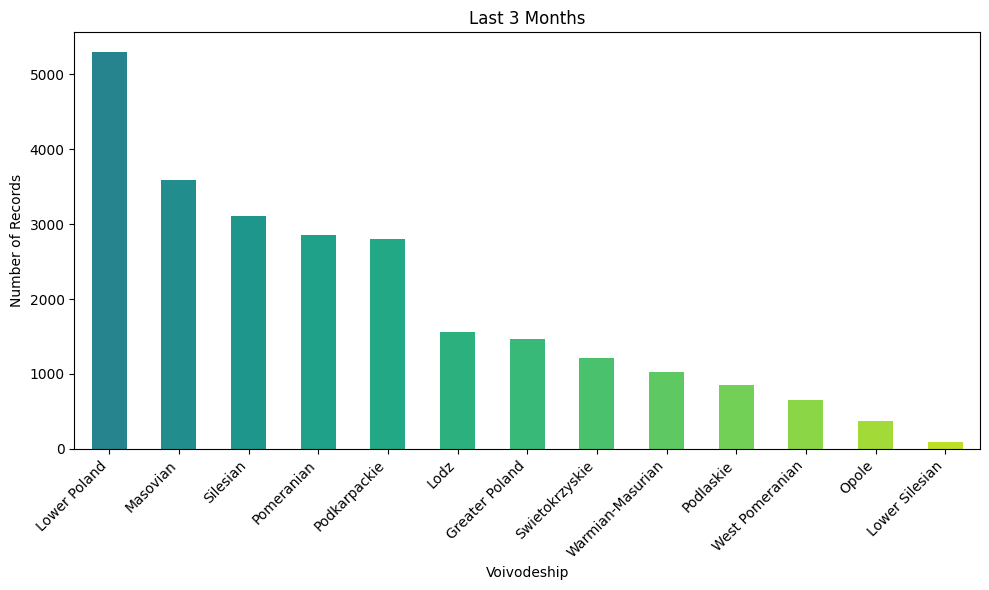

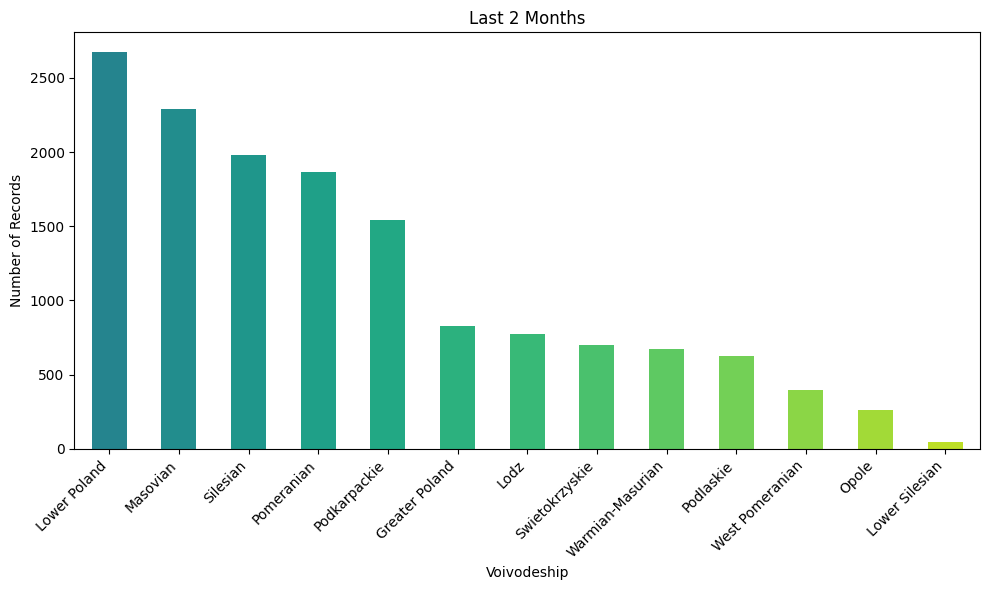

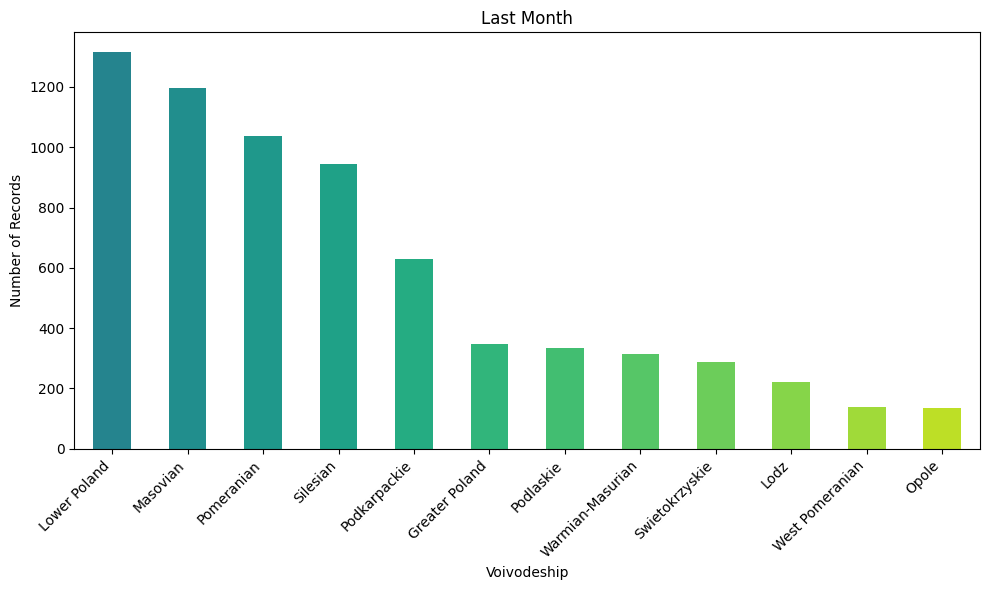

In [12]:
# Convert the 'data_wplywu_wniosku_do_urzedu' column to datetime objects
df['data_wplywu_wniosku_do_urzedu'] = pd.to_datetime(df['data_wplywu_wniosku_do_urzedu'])

# Define the end date (latest date in the data)
end_date = df['data_wplywu_wniosku_do_urzedu'].max()

# Calculate the start dates for three time periods (3 months, 2 months, 1 month)
three_months_ago = end_date - timedelta(days=90)
two_months_ago = end_date - timedelta(days=60)
one_month_ago = end_date - timedelta(days=30)

# Filter the data for each time period
df_three_months = df[df['data_wplywu_wniosku_do_urzedu'] >= three_months_ago]
df_two_months = df[df['data_wplywu_wniosku_do_urzedu'] >= two_months_ago]
df_one_month = df[df['data_wplywu_wniosku_do_urzedu'] >= one_month_ago]

# Generate plots with the same colors and axis labels as the specified plot
def generate_plot(data, title):
    data = data[data['voivodeship'] != 'Unknown']  # Remove records with 'Unknown' in the 'voivodeship' column
    voivodeship_counts = data['voivodeship'].value_counts()

    # Use viridis color palette
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(voivodeship_counts)))

    plt.figure(figsize=(10, 6))
    voivodeship_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Voivodeship')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

generate_plot(df_three_months, 'Last 3 Months')
generate_plot(df_two_months, 'Last 2 Months')
generate_plot(df_one_month, 'Last Month')


### Plots with building application per example voivodship of Lower Poland per powiat from last 3,2 and 1 month

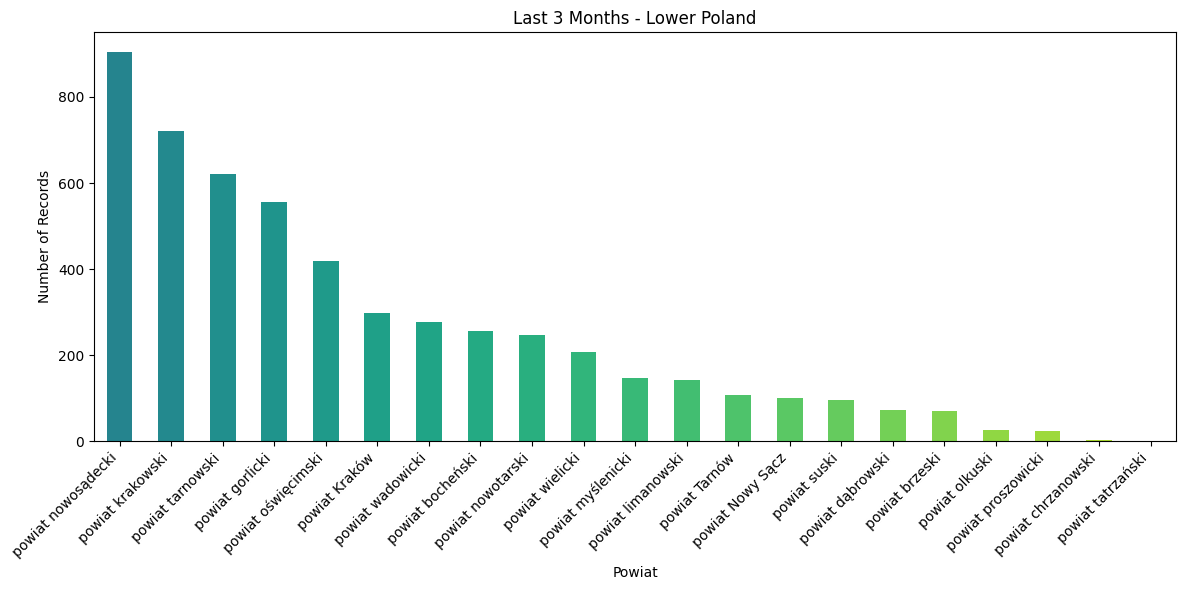

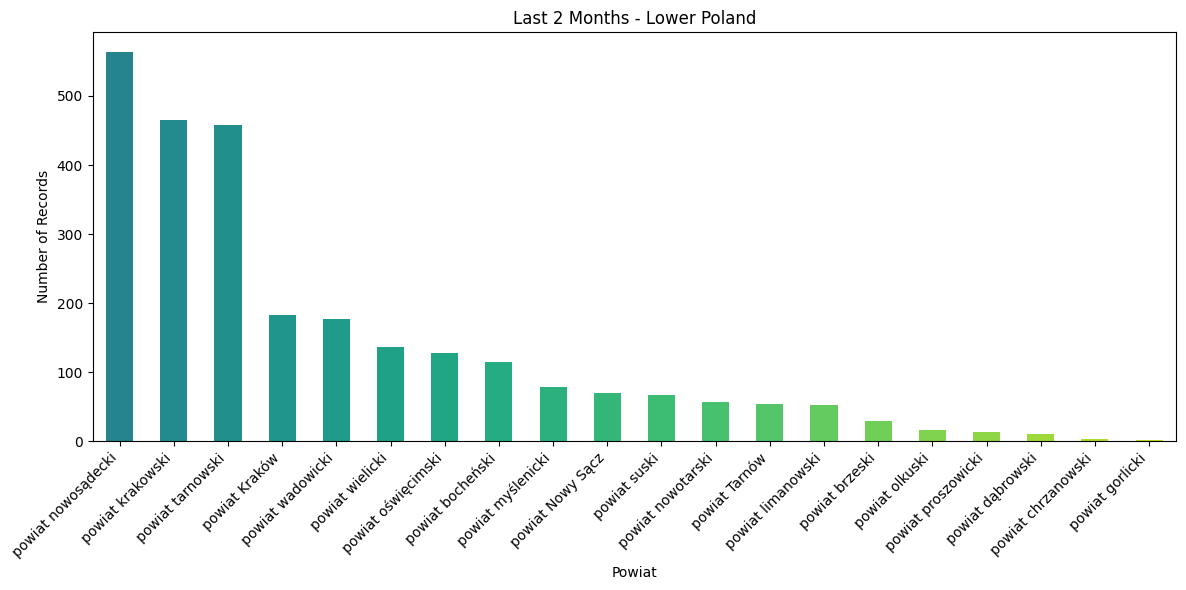

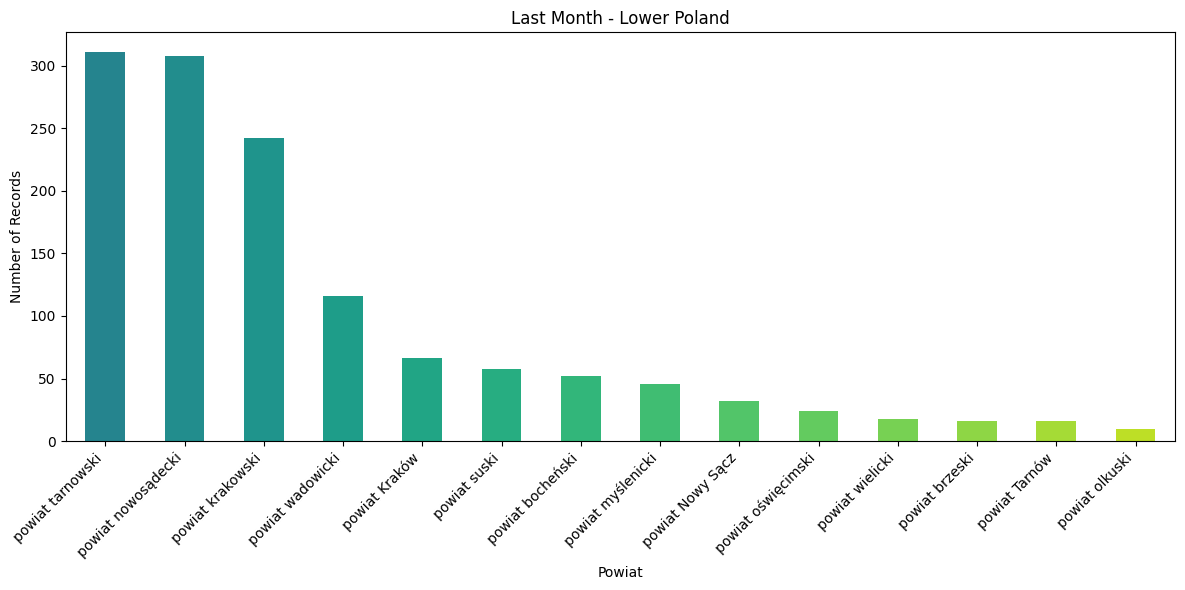

In [13]:
# Convert the 'data_wplywu_wniosku_do_urzedu' column to datetime objects
df['data_wplywu_wniosku_do_urzedu'] = pd.to_datetime(df['data_wplywu_wniosku_do_urzedu'])

# Define the end date (latest date in the data)
end_date = df['data_wplywu_wniosku_do_urzedu'].max()

# Calculate the start dates for three time periods (3 months, 2 months, 1 month)
three_months_ago = end_date - timedelta(days=90)
two_months_ago = end_date - timedelta(days=60)
one_month_ago = end_date - timedelta(days=30)

# Filter the data for each time period
df_three_months = df[df['data_wplywu_wniosku_do_urzedu'] >= three_months_ago]
df_two_months = df[df['data_wplywu_wniosku_do_urzedu'] >= two_months_ago]
df_one_month = df[df['data_wplywu_wniosku_do_urzedu'] >= one_month_ago]

# Generate plots for Małopolskie voivodeship with county breakdown
def generate_plot_with_counties(data, title, voivodeship_name='Lower Poland'):
    # Filter data for Małopolskie voivodeship
    małopolskie_data = data[data['voivodeship'] == voivodeship_name]
    
    # Remove records with 'Unknown' in the 'powiat' column
    małopolskie_data = małopolskie_data[małopolskie_data['powiat'] != 'Unknown']
    
    # Count occurrences of each powiat
    powiat_counts = małopolskie_data['powiat'].value_counts()
    
    # Determine the number of unique powiats and the corresponding number of colors
    num_unique_powiats = len(powiat_counts)
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, num_unique_powiats))

    plt.figure(figsize=(12, 6))
    powiat_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Powiat')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

generate_plot_with_counties(df_three_months, 'Last 3 Months - Lower Poland')
generate_plot_with_counties(df_two_months, 'Last 2 Months - Lower Poland')
generate_plot_with_counties(df_one_month, 'Last Month - Lower Poland')


### Creating a visualisation map - Voivodship test

/opt/conda/lib/python3.11/site-packages/geopandas/geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_206/2080466141.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  map['ilość_pozwoleń'].fillna(0, inplace=True)
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDep

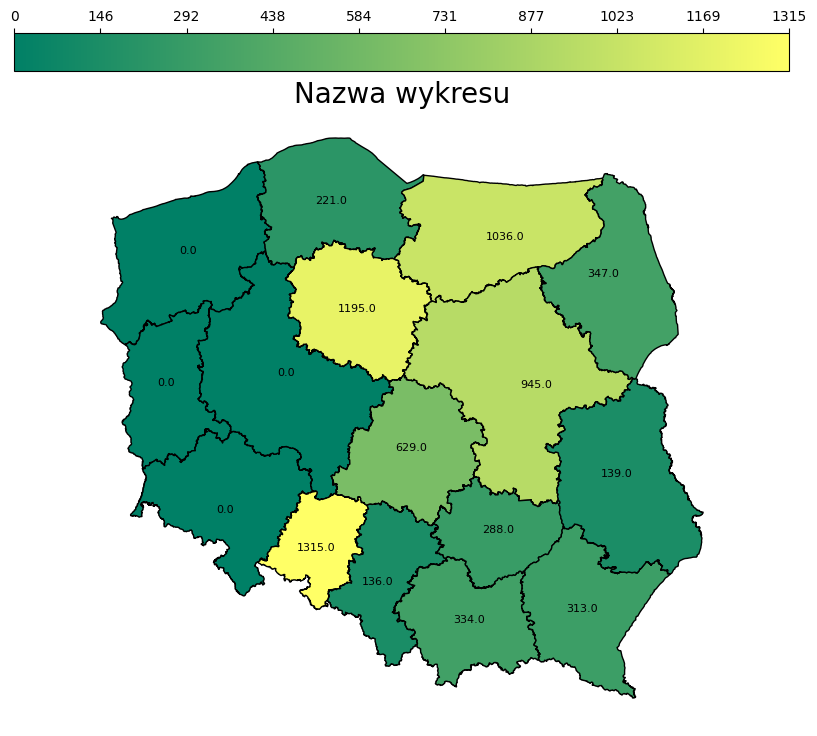

In [19]:
map = gpd.read_file('../wojewodztwa/wojewodztwa.shp')

# Tworzymy listęwojewództw z uporządkowaniem na podstawie tabeli GIS
map['woj'] = [
    'Lower Silesian',
    'Kuyavian-Pomeranian',
    'Lublin',
    'Lubusz',
    'Lodz',
    'Lower Poland',
    'Masovian',
    'Opole',
    'Podkarpackie',
    'Podlaskie',
    'Pomeranian',
    'Silesian',
    'Swietokrzyskie',
    'Warmian-Masurian',
    'Greater Poland',
    'West Pomeranian'
]

# Ustalenie lokalizacji wyświetlania ilości wydanych pozwoleń (środek kształtu województwa)
map['coords'] = map['geometry'].apply(
    lambda x: x.representative_point().coords[:])
map['coords'] = [coords[0] for coords in map['coords']]




#.....Obliczanie sumarycznej ilości wydanych pozwoleń w ramach województwa z np. ostatniego miesiąca..............
voivodeship_counts = df_one_month['voivodeship'].value_counts()

map['ilość_pozwoleń'] = map['woj'].map(voivodeship_counts)

# W przypadku braku danych dla niektórych województw, możemy chcieć uzupełnić te luki zerami
map['ilość_pozwoleń'].fillna(0, inplace=True)




#Generowanie wykresu
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Nazwa wykresu',
          fontsize=20
         )
#Tworzenie colormap z colorbar
vmin = map['ilość_pozwoleń'].min()
vmax = map['ilość_pozwoleń'].max()
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='summer')
color = [mappable.to_rgba(item) for item in map['ilość_pozwoleń']]
fig.colorbar(mappable,ax=ax,location='top',ticks=np.linspace(start=vmin, stop=vmax, num=10))

map.plot(ax=ax, color=color, edgecolor='black')
ax.axis('off')
for idx, row in map.iterrows():
    plt.annotate(
        text=row['ilość_pozwoleń'],
        xy=row['coords'],
        horizontalalignment='center',
        color='black',
        fontsize=8)

### Creating a visualisation map - powiat test

In [16]:
map1 = gpd.read_file('../powiaty/powiaty.shp')

print(map1.columns)

print(map1.head())


Index(['gml_id', 'JPT_SJR_KO', 'JPT_POWIER', 'JPT_KOD_JE', 'JPT_NAZWA_',
       'JPT_ORGAN_', 'JPT_JOR_ID', 'WERSJA_OD', 'WERSJA_DO', 'WAZNY_OD',
       'WAZNY_DO', 'JPT_KOD__1', 'JPT_NAZWA1', 'JPT_ORGAN1', 'JPT_WAZNA_',
       'ID_BUFORA_', 'ID_BUFORA1', 'ID_TECHNIC', 'IIP_PRZEST', 'IIP_IDENTY',
       'IIP_WERSJA', 'JPT_KJ_IIP', 'JPT_KJ_I_1', 'JPT_KJ_I_2', 'JPT_OPIS',
       'JPT_SPS_KO', 'ID_BUFOR_1', 'JPT_ID', 'JPT_POWI_1', 'JPT_KJ_I_3',
       'JPT_GEOMET', 'JPT_GEOM_1', 'SHAPE_LENG', 'SHAPE_AREA', 'REGON',
       'RODZAJ', 'geometry'],
      dtype='object')
  gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE          JPT_NAZWA_ JPT_ORGAN_  \
0   None        POW      92617       1807  powiat krośnieński       None   
1   None        POW     141297       2804     powiat elbląski       None   
2   None        POW     209827       1415   powiat ostrołęcki       None   
3   None        POW      79097       0413   powiat sępoleński       None   
4   None        POW     126576       3019       po

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use 

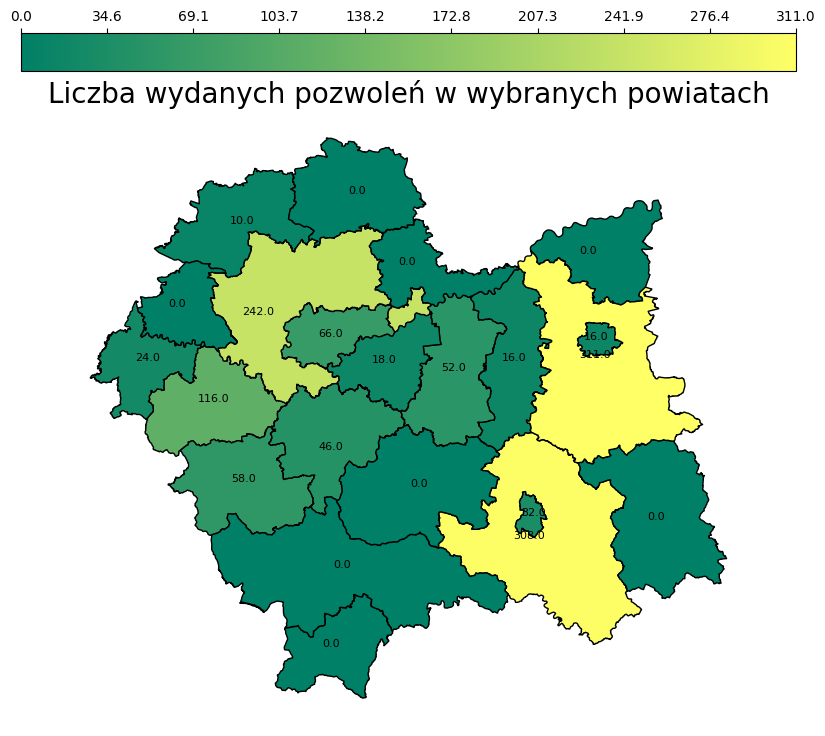

In [24]:
# Lista powiatów do wizualizacji z dodanymi przedrostkami 'powiat'
powiaty_do_wizualizacji = [
    'powiat bocheński', 'powiat brzeski', 'powiat chrzanowski', 'powiat dąbrowski', 'powiat gorlicki',
    'powiat krakowski', 'powiat limanowski', 'powiat miechowski', 'powiat myślenicki', 'powiat nowosądecki',
    'powiat nowotarski', 'powiat olkuski', 'powiat oświęcimski', 'powiat proszowicki', 'powiat suski',
    'powiat tarnowski', 'powiat tatrzański', 'powiat wadowicki', 'powiat wielicki', 'powiat Kraków',
    'powiat Nowy Sącz', 'powiat Tarnów'
]

# Filtrowanie danych GIS, aby uwzględnić tylko powiaty z województwa małopolskiego
map1_filtered = map1[
    (map1['JPT_NAZWA_'].isin(powiaty_do_wizualizacji)) &
    (map1['JPT_KOD_JE'].str.startswith('12'))
]

# Kontynuacja z przetwarzaniem współrzędnych i przygotowaniem danych
# Odpowiednie stosowanie metody apply() zgodnie z ostrzeżeniem
map1_filtered.loc[:, 'coords'] = map1_filtered['geometry'].astype(object).apply(lambda x: x.representative_point().coords[:])
map1_filtered.loc[:, 'coords'] = map1_filtered['coords'].apply(lambda x: x[0])

# Przypisywanie liczby wydanych pozwoleń
map1_filtered.loc[:, 'ilość_pozwoleń'] = map1_filtered['JPT_NAZWA_'].map(powiat_counts)

# Uzupełnianie brakujących danych zerami
map1_filtered.loc[:, 'ilość_pozwoleń'] = map1_filtered['ilość_pozwoleń'].fillna(0)

# Generowanie wykresu
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Liczba wydanych pozwoleń w wybranych powiatach', fontsize=20)

# Tworzenie colormap z colorbar
vmin = map1_filtered['ilość_pozwoleń'].min() if not pd.isna(map1_filtered['ilość_pozwoleń'].min()) else 0
vmax = map1_filtered['ilość_pozwoleń'].max() if not pd.isna(map1_filtered['ilość_pozwoleń'].max()) else 1
mappable = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='summer')
color = [mappable.to_rgba(item) for item in map1_filtered['ilość_pozwoleń']]
fig.colorbar(mappable, ax=ax, location='top', ticks=np.linspace(start=vmin, stop=vmax, num=10))

# Rysowanie mapy
map1_filtered.plot(ax=ax, color=color, edgecolor='black')
ax.axis('off')
for idx, row in map1_filtered.iterrows():
    plt.annotate(
        text=row['ilość_pozwoleń'],
        xy=row['coords'],
        horizontalalignment='center',
        color='black',
        fontsize=8)
